In [1]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms


In [2]:
torch.manual_seed(111)


In [3]:
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")


# Preparing the Training Data

The MNIST dataset consists of 28 × 28 pixel grayscale images of handwritten digits from 0 to 9. To use them with PyTorch, you’ll need to perform some conversions. For that, you define transform, a function to be used when loading the data:
The function has two parts:

    transforms.ToTensor() converts the data to a PyTorch tensor.
    transforms.Normalize() converts the range of the tensor coefficients.


In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)


In [5]:
train_set = torchvision.datasets.MNIST(
    root=".", train=True, download=True, transform=transform
)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



The argument download=True ensures that the first time you run the above code, the MNIST dataset will be downloaded and stored in the current directory, as indicated by the argument root.

In [6]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)


You can use Matplotlib to plot some samples of the training data. To improve the visualization, you can use cmap=gray_r to reverse the color map and plot the digits in black over a white background

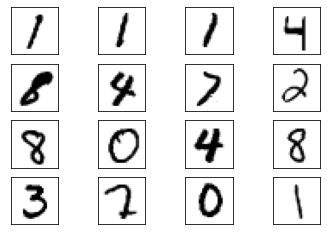

In [7]:
real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(real_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])


As you can see, there are digits with different handwriting styles. As the GAN learns the distribution of the data, it’ll also generate digits with different handwriting styles.

In [8]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
            nn.Linear(784, 1024), # The input is two-dimensional, and the first hidden layer is composed of 1024 neurons with ReLU activation.
            nn.ReLU(),
            nn.Dropout(0.3), #    use dropout to avoid overfitting.
            nn.Linear(1024, 512), #The second and third hidden layers are composed of 512 and 256 neurons, respectively, with ReLU activation.
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1), #The output is composed of a single neuron with sigmoidal activation to represent a probability.
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output
#After the first, second, and third hidden layers, you use dropout to avoid overfitting.
#.forward() to describe how the output of the model is calculated. Here, x represents the input of the model, which is a two-dimensional tensor. In this implementation, the output is obtained by feeding the input x to the model you’ve defined without any other processing.

In [9]:
discriminator = Discriminator().to(device=device)#instantiate a Discriminator object


# Implementing the Generator

* the generator is the model that takes samples from a latent space as its input and generates data resembling the data in the training set.
* the generator is going to generate more complex data, it’s necessary to increase the dimensions of the input from the latent space. In this case, the generator is going to be fed a 100-dimensional input and will provide an output with 784 coefficients, which will be organized in a 28 × 28 tensor representing an image.

In [10]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
#t’s composed of four hidden layers with 256,512 and 1024 neurons, both with ReLU activation, and a linear activation layer with 2 neurons in the output. 
    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output


generator = Generator().to(device=device)


the hyperbolic tangent function Tanh() as the activation of the output layer since the output coefficients should be in the interval from -1 to 1. 

you instantiate the generator and send it to device to use the GPU if one is available.

# Training the Models

In [11]:
lr = 0.0001 #sets the learning rate (lr), which you’ll use to adapt the network weights
num_epochs = 50 #sets the number of epochs (num_epochs), which defines how many repetitions of training using the whole training set will be performed.
loss_function = nn.BCELoss() #assigns the variable loss_function to the binary cross-entropy function BCELoss(), which is the loss function that you’ll use to train the models.

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)


The binary cross-entropy function is a suitable loss function for training the discriminator because it considers a binary classification task. It’s also suitable for training the generator since it feeds its output to the discriminator, which provides a binary observable output.

Finally, you need to implement a training loop in which training samples are fed to the models, and their weights are updated to minimize the loss function:



In [12]:
for epoch in range(num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(
            device=device
        )
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(
            device=device
        )
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )
        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels
        )
        loss_discriminator.backward()
        optimizer_discriminator.step()
        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )
        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()
        # Show loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.5889771580696106
Epoch: 0 Loss G.: 0.4736277759075165
Epoch: 1 Loss D.: 0.06094331666827202
Epoch: 1 Loss G.: 5.646681785583496
Epoch: 2 Loss D.: 0.05521972477436066
Epoch: 2 Loss G.: 5.326852321624756
Epoch: 3 Loss D.: 0.04278045520186424
Epoch: 3 Loss G.: 5.215598106384277
Epoch: 4 Loss D.: 0.15021733939647675
Epoch: 4 Loss G.: 5.817656517028809
Epoch: 5 Loss D.: 0.01096605695784092
Epoch: 5 Loss G.: 5.595632553100586
Epoch: 6 Loss D.: 0.10195364058017731
Epoch: 6 Loss G.: 3.848248243331909
Epoch: 7 Loss D.: 0.0594065897166729
Epoch: 7 Loss G.: 3.7994749546051025
Epoch: 8 Loss D.: 0.15992523729801178
Epoch: 8 Loss G.: 3.711686134338379
Epoch: 9 Loss D.: 0.11395362764596939
Epoch: 9 Loss G.: 2.9194529056549072
Epoch: 10 Loss D.: 0.045616112649440765
Epoch: 10 Loss G.: 4.341765880584717
Epoch: 11 Loss D.: 0.28139248490333557
Epoch: 11 Loss G.: 2.2495312690734863
Epoch: 12 Loss D.: 0.28380244970321655
Epoch: 12 Loss G.: 3.0105137825012207
Epoch: 13 Loss D.: 0.4266991

## Checking the Samples Generated by the GAN

To plot generated_samples, you need to move the data back to the CPU in case it’s running on the GPU. For that, you can simply call .cpu(). As you did previously, you also need to call .detach() before using Matplotlib to plot the data

In [13]:
latent_space_samples = torch.randn(batch_size, 100).to(device=device)
generated_samples = generator(latent_space_samples)


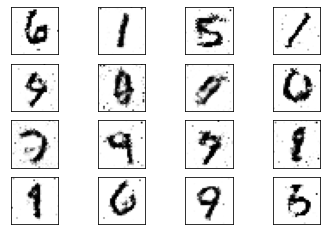

In [14]:
generated_samples = generated_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])


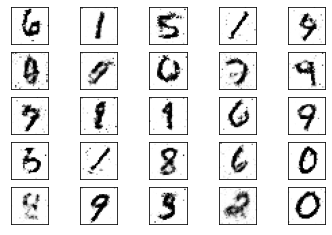

In [17]:
generated_samples = generated_samples.cpu().detach()
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])
